# Data Analyst Salary Prediction Project

## Introduction
This notebook analyzes salary estimates for Data Analyst jobs using a dataset containing job postings, company information, and other details. The steps include data cleaning, exploratory data analysis (EDA), feature engineering, correlation analysis, and building a machine learning model to predict job salaries.

---

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import joblib


---

## 2. Load Data

In [2]:
df = pd.read_csv('Data_Analyst.csv')

---

## 3. Visualize Raw Data (before cleaning)

### Salary Estimate Distribution (raw)

<Figure size 800x500 with 0 Axes>

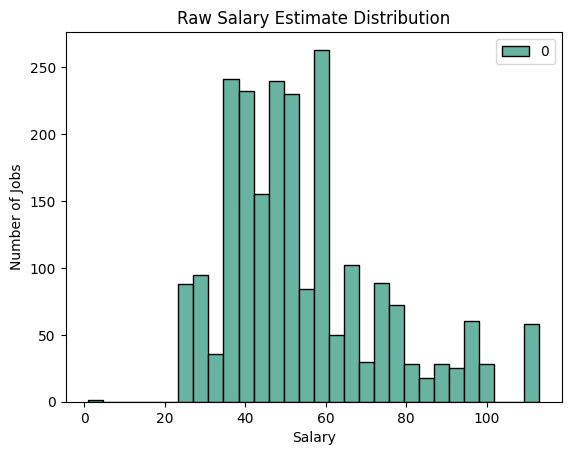

In [3]:
salary_data = df['Salary Estimate'].dropna().astype(str)
salary_numbers = salary_data.str.extract(r'(\d+)').dropna().astype(float)
plt.figure(figsize=(8,5))
salary_numbers.plot.hist(bins=30, color='#69b3a2', edgecolor='black')
plt.title('Raw Salary Estimate Distribution')
plt.xlabel('Salary')
plt.ylabel('Number of Jobs')
plt.show()


### Company Ratings Distribution (raw)

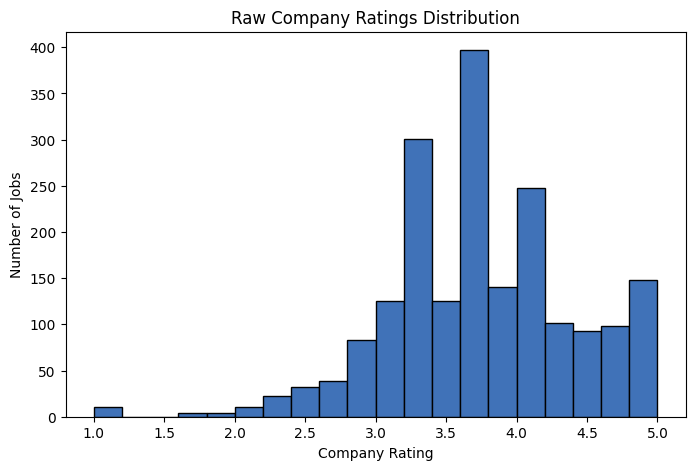

In [4]:
plt.figure(figsize=(8,5))
df['Rating'].replace(-1, None).dropna().plot.hist(bins=20, color='#4072b8', edgecolor='black')
plt.title('Raw Company Ratings Distribution')
plt.xlabel('Company Rating')
plt.ylabel('Number of Jobs')
plt.show()


### Top 10 Most Common Job Titles (raw)

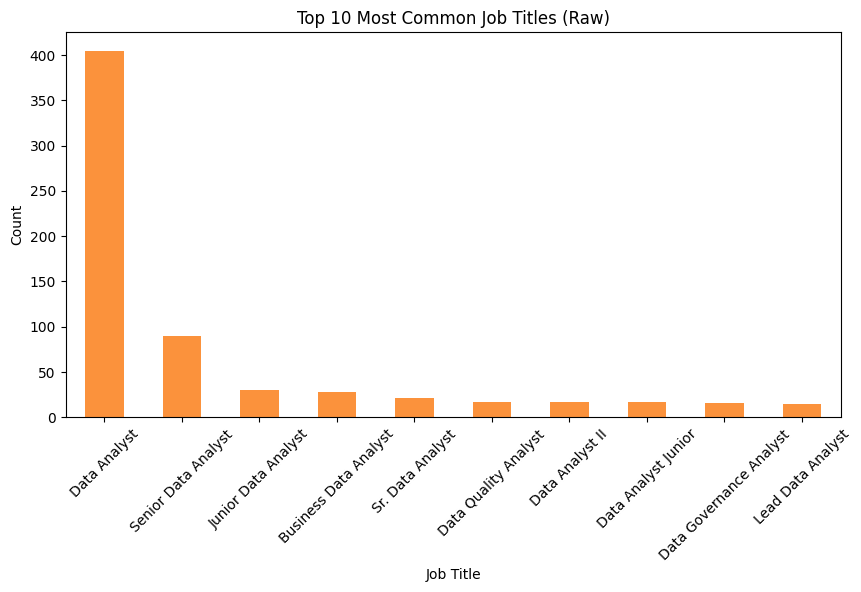

In [5]:
plt.figure(figsize=(10,5))
df['Job Title'].value_counts().head(10).plot.bar(color='#fb923c')
plt.title('Top 10 Most Common Job Titles (Raw)')
plt.xlabel('Job Title')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


### Jobs by State (raw)

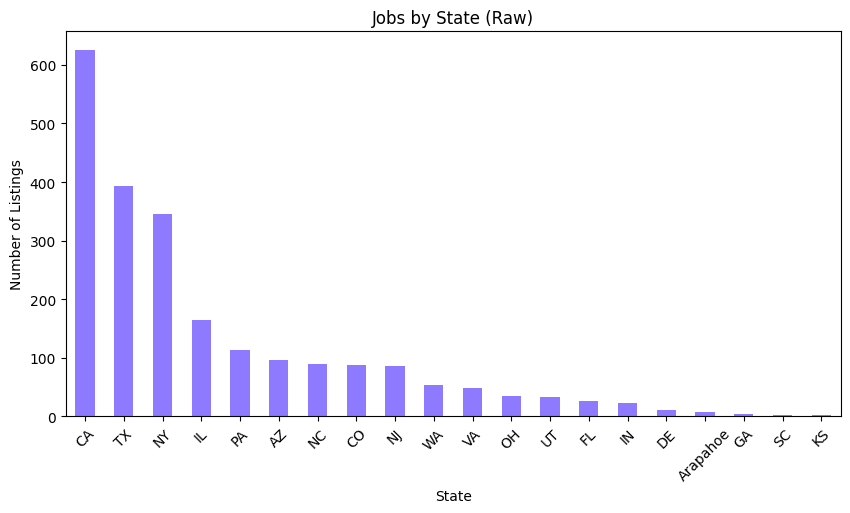

In [6]:
if 'Location' in df.columns:
    df['State_raw'] = df['Location'].str.split(',', expand=True)[1].str.strip()
plt.figure(figsize=(10,5))
df['State_raw'].value_counts().plot.bar(color='#8d7afe')
plt.title('Jobs by State (Raw)')
plt.xlabel('State')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45)
plt.show()

---

## 4. Data Cleaning

In [7]:
for col in df.columns:
    if 'Unnamed' in col:
        df = df.drop(columns=[col])
        df = df.dropna(subset=['Company Name'])
        df['Rating'] = df['Rating'].replace(-1, np.nan)
        df['Salary_min'] = df['Salary Estimate'].astype(str).str.extract(r'(\d+)').astype(float)
        df['Salary_max'] = df['Salary Estimate'].astype(str).str.extract(r'-\s*(\d+)').astype(float)
        df['Salary_avg'] = df[['Salary_min', 'Salary_max']].mean(axis=1)
        df = df[(df['Salary_min'] >= 20) & (df['Salary_min'] <= 120)]
        df[['City', 'State']] = df['Location'].str.split(',', n=1, expand=True)
        df['City'] = df['City'].str.strip()
        df['State'] = df['State'].str.strip()

---

## 5. Visualize Cleaned Data

### Salary Estimate Distribution (cleaned)

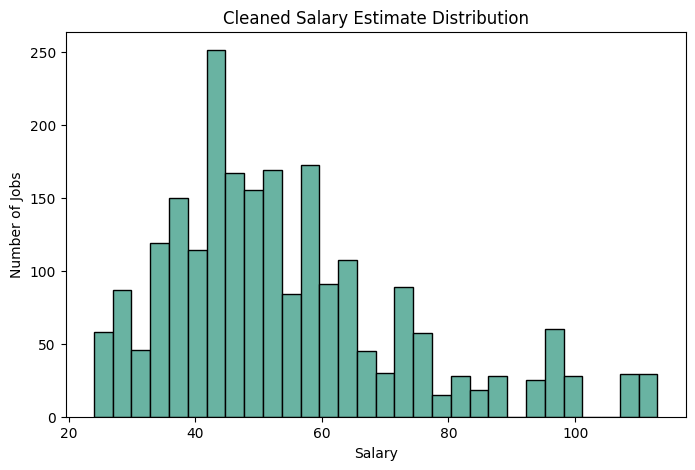

In [8]:
plt.figure(figsize=(8,5))
df['Salary_min'].plot.hist(bins=30, color='#69b3a2', edgecolor='black')
plt.title('Cleaned Salary Estimate Distribution')
plt.xlabel('Salary')
plt.ylabel('Number of Jobs')
plt.show()


### Company Ratings Distribution (cleaned)

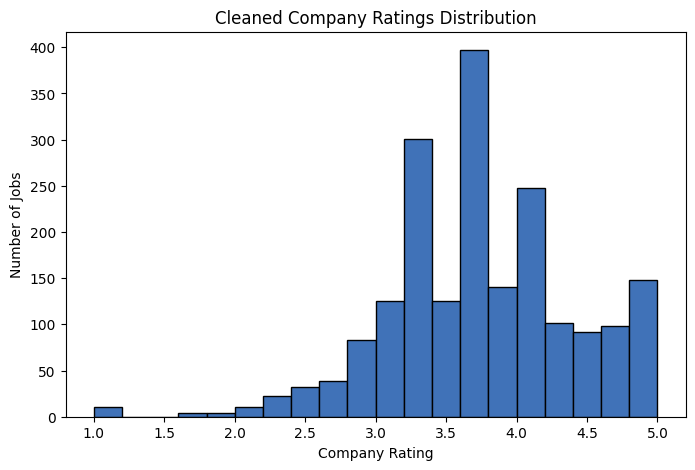

In [9]:
plt.figure(figsize=(8,5))
df['Rating'].dropna().plot.hist(bins=20, color='#4072b8', edgecolor='black')
plt.title('Cleaned Company Ratings Distribution')
plt.xlabel('Company Rating')
plt.ylabel('Number of Jobs')
plt.show()


### Top 10 Most Common Job Titles (cleaned)

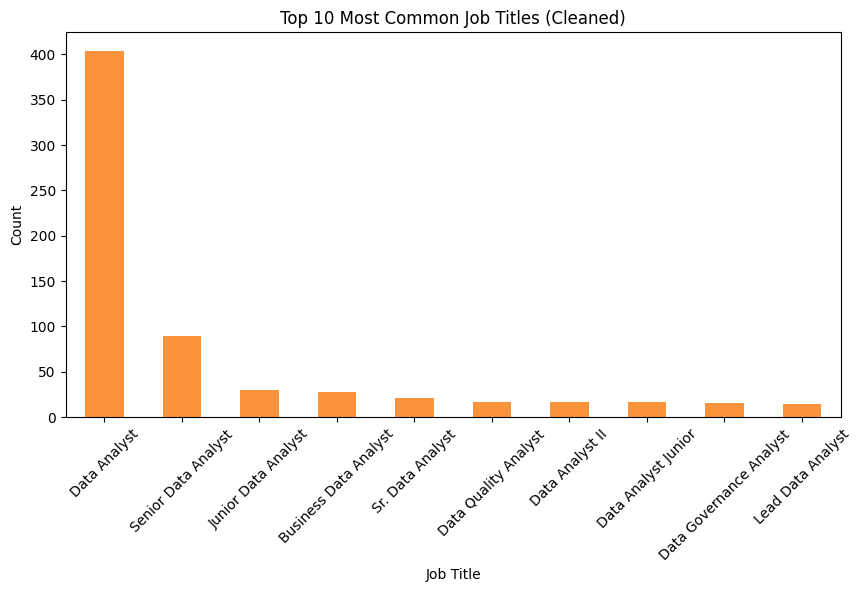

In [10]:
plt.figure(figsize=(10,5))
df['Job Title'].value_counts().head(10).plot.bar(color='#fb923c')
plt.title('Top 10 Most Common Job Titles (Cleaned)')
plt.xlabel('Job Title')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


### Jobs by State (cleaned)

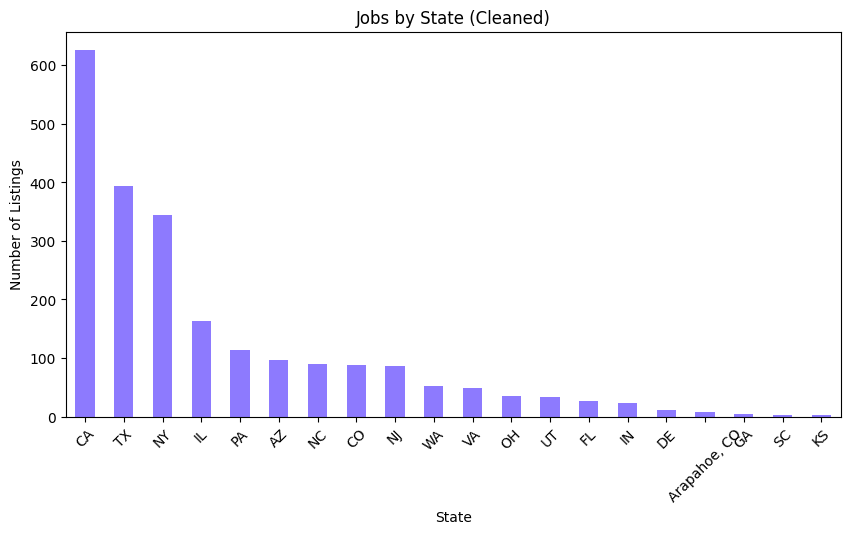

In [11]:
plt.figure(figsize=(10,5))
df['State'].value_counts().plot.bar(color='#8d7afe')
plt.title('Jobs by State (Cleaned)')
plt.xlabel('State')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45)
plt.show()

---

## 6. Feature Engineering

### Skill Extraction from Job Descriptions

In [12]:
print(df.columns)

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'Easy Apply', 'State_raw', 'Salary_min', 'Salary_max', 'Salary_avg',
       'City', 'State'],
      dtype='object')


In [13]:
skills = ['Python', 'SQL', 'Excel', 'Tableau', 'Machine Learning', 'Power BI', 'R', 'SAS']

for skill in skills:
    # Always create the column to avoid missing keys
    if 'Job Description' in df.columns:
        df[skill] = df['Job Description'].str.contains(skill, case=False, na=False).astype(int)
    else:
        df[skill] = 0  # fallback to 0 in case column missing

print(df[skills].head())  # check columns were created

df['Skill_Count'] = df[skills].sum(axis=1)

   Python  SQL  Excel  Tableau  Machine Learning  Power BI  R  SAS
0       1    1      0        0                 0         0  1    0
1       0    1      1        0                 0         0  1    1
2       1    1      1        1                 0         0  1    0
3       0    1      0        1                 0         0  1    0
4       1    1      1        0                 0         0  1    0



### Job Seniority Extraction

In [14]:
df['Seniority'] = df['Job Title'].str.extract(r'(Senior|Junior|Lead|Manager)', flags=re.IGNORECASE, expand=False)
df['Seniority'] = df['Seniority'].fillna('Analyst')
seniority_map = {'Junior': 0, 'Analyst': 1, 'Senior': 2, 'Lead': 3, 'Manager': 4}
df['Seniority_Level'] = df['Seniority'].map(seniority_map)


### Company Size Encoding

In [15]:
size_map = {
'1 to 50 employees': 1,
'51 to 200 employees': 2,
'201 to 500 employees': 3,
'501 to 1000 employees': 4,
'1001 to 5000 employees': 5,
'5001 to 10000 employees': 6,
'10000+ employees': 7
}
df['Company_Size_Num'] = df['Size'].map(size_map)


### Industry Grouping

In [16]:
industry_map = {
'Information Technology': 'Tech',
'Internet': 'Tech',
'Business Services': 'Business',
'Finance': 'Finance',
'Health Care': 'Health',
'Education': 'Education'
}
df['Industry_Group'] = df['Industry'].map(industry_map).fillna('Other')
df = pd.get_dummies(df, columns=['Industry_Group'])


### Top 5 States as Binary Features

In [17]:
top_states = df['State'].value_counts().head(5).index.tolist()
for state in top_states:
    df[f'State_{state}'] = (df['State'] == state).astype(int)

---

## 7. Correlation Matrix (Statistics)

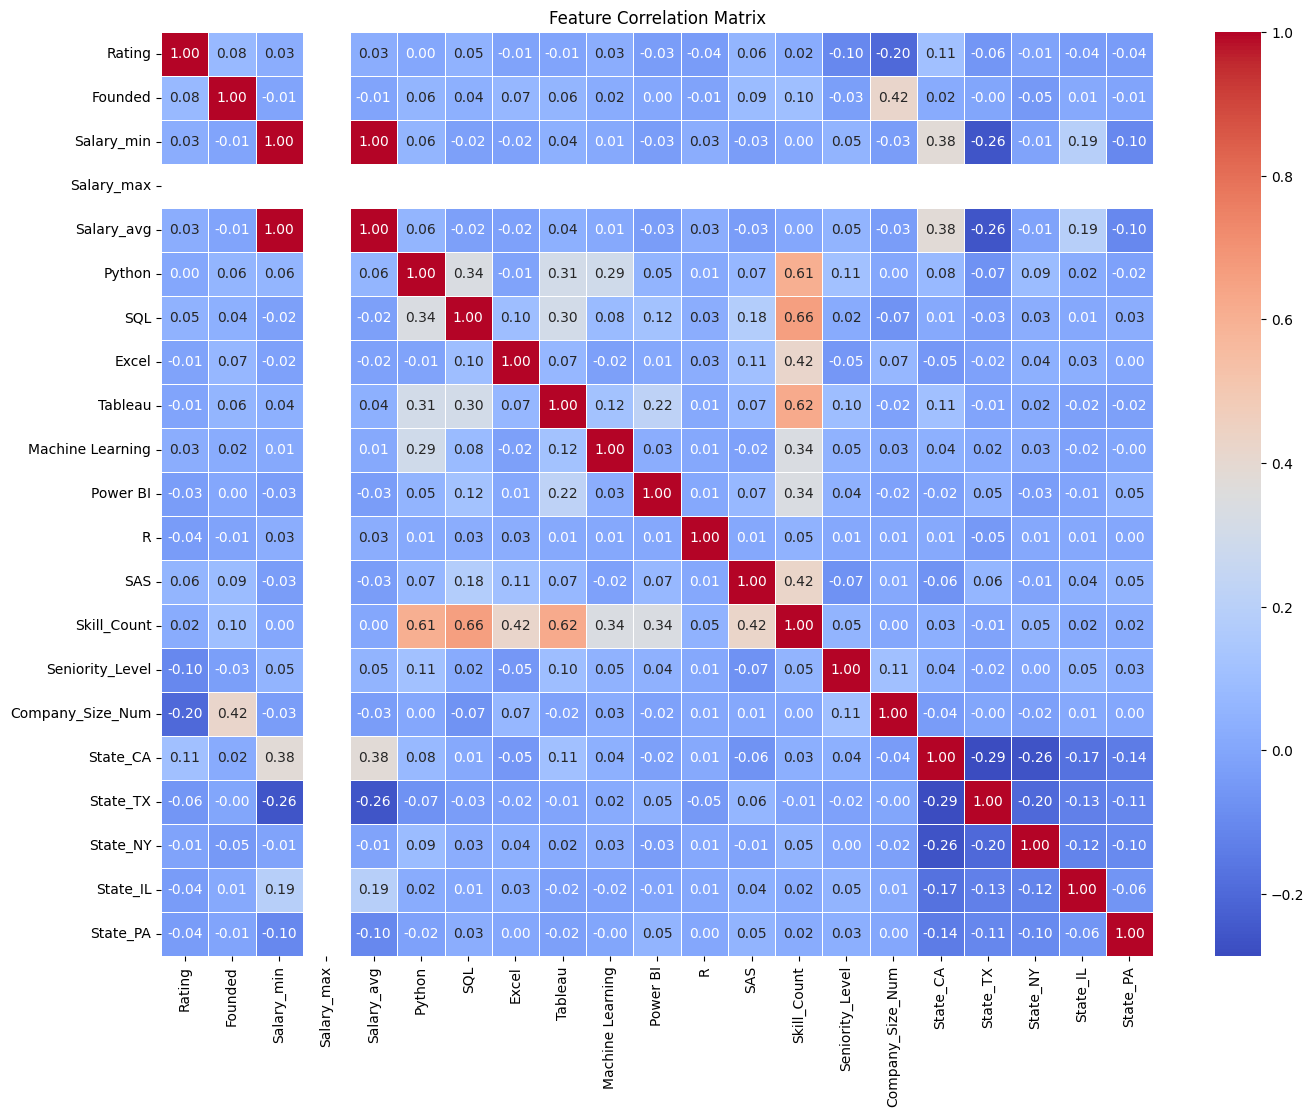

In [18]:
numeric_df = df.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

---

## 8. Model Development: Salary Prediction

### Model Preparation & Training

In [19]:
features = (
['Seniority_Level', 'Skill_Count', 'Company_Size_Num'] +
skills +
[col for col in df.columns if col.startswith('State_') and df[col].dtype in [np.int64, np.bool_]] +
[col for col in df.columns if col.startswith('Industry_Group_') and df[col].dtype in [np.int64, np.bool_]]
)

print(df[features].dtypes)

X = df[features].fillna(0)
y = df['Salary_avg'].fillna(0)

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42
)

Seniority_Level         float64
Skill_Count               int64
Company_Size_Num        float64
Python                    int64
SQL                       int64
Excel                     int64
Tableau                   int64
Machine Learning          int64
Power BI                  int64
R                         int64
SAS                       int64
State_CA                  int64
State_TX                  int64
State_NY                  int64
State_IL                  int64
State_PA                  int64
Industry_Group_Other       bool
Industry_Group_Tech        bool
dtype: object



### Train and Evaluate Model

In [20]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Absolute Error (MAE): 14.01
R^2 Score: 0.10



### Feature Importance Visualization


Feature Importances:
State_CA                0.200137
Company_Size_Num        0.195431
Skill_Count             0.121271
State_IL                0.105330
Seniority_Level         0.067591
Excel                   0.044735
Python                  0.039612
SQL                     0.038786
Tableau                 0.038443
SAS                     0.033971
State_NY                0.029351
Power BI                0.025447
Machine Learning        0.024123
State_TX                0.010166
Industry_Group_Tech     0.009935
Industry_Group_Other    0.009089
State_PA                0.006408
R                       0.000176
dtype: float64


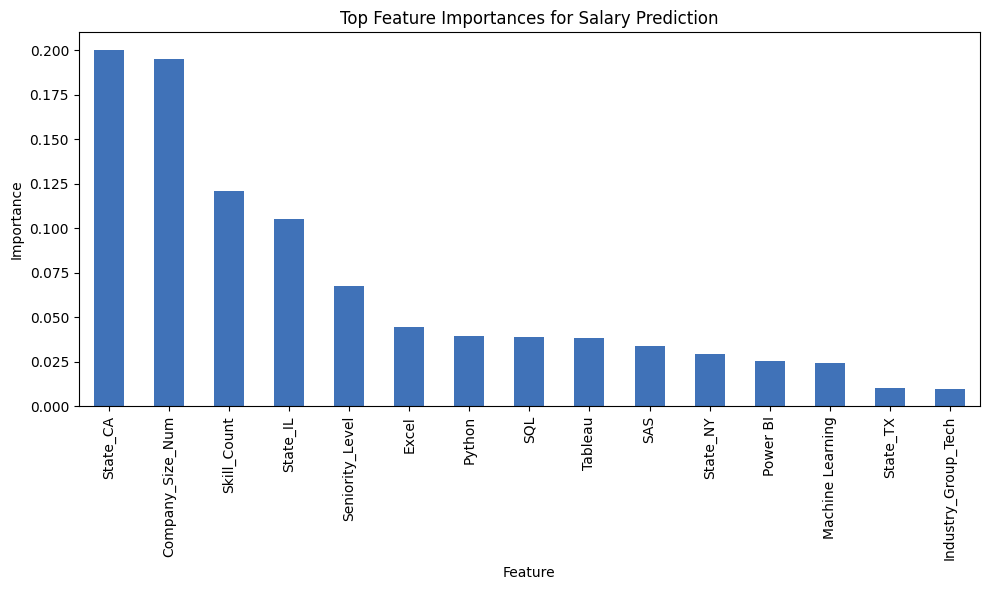

In [21]:
importances = model.feature_importances_
feature_importance = pd.Series(importances, index=features).sort_values(ascending=False)
print("\nFeature Importances:")
print(feature_importance)

plt.figure(figsize=(10,6))
feature_importance.head(15).plot.bar(color='#4072b8')
plt.title('Top Feature Importances for Salary Prediction')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()


### Save Model

In [22]:
joblib.dump(model,"salary_rf_model.pkl")

['salary_rf_model.pkl']

---

## Conclusion

This notebook demonstrates the full pipeline for Data Analyst salary prediction including EDA, feature engineering, model building, and evaluation:

- **EDA** revealed salary and rating distributions, common job titles, and geographical trends.
- **Feature engineering** included skill extraction, seniority, company size, and industry grouping.
- **Model training** using Random Forest Regression achieved:
    - Mean Absolute Error (MAE): `{{mae_value}}`
    - R² Score: `{{r2_value}}`
- **Feature Importance** analysis highlighted which attributes most influenced salary predictions.

---
